In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import category_encoders as ce

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [18]:
df = pd.read_csv('train.csv')

In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [21]:
# Chaninging column names to make features easier to interpret
df = df.rename(columns={'SibSp': 'siblings_spouses_aboard', 'Parch': 'parents_children_aboard', 'Embarked': 'port_of_embarkment'})

# Missing Values

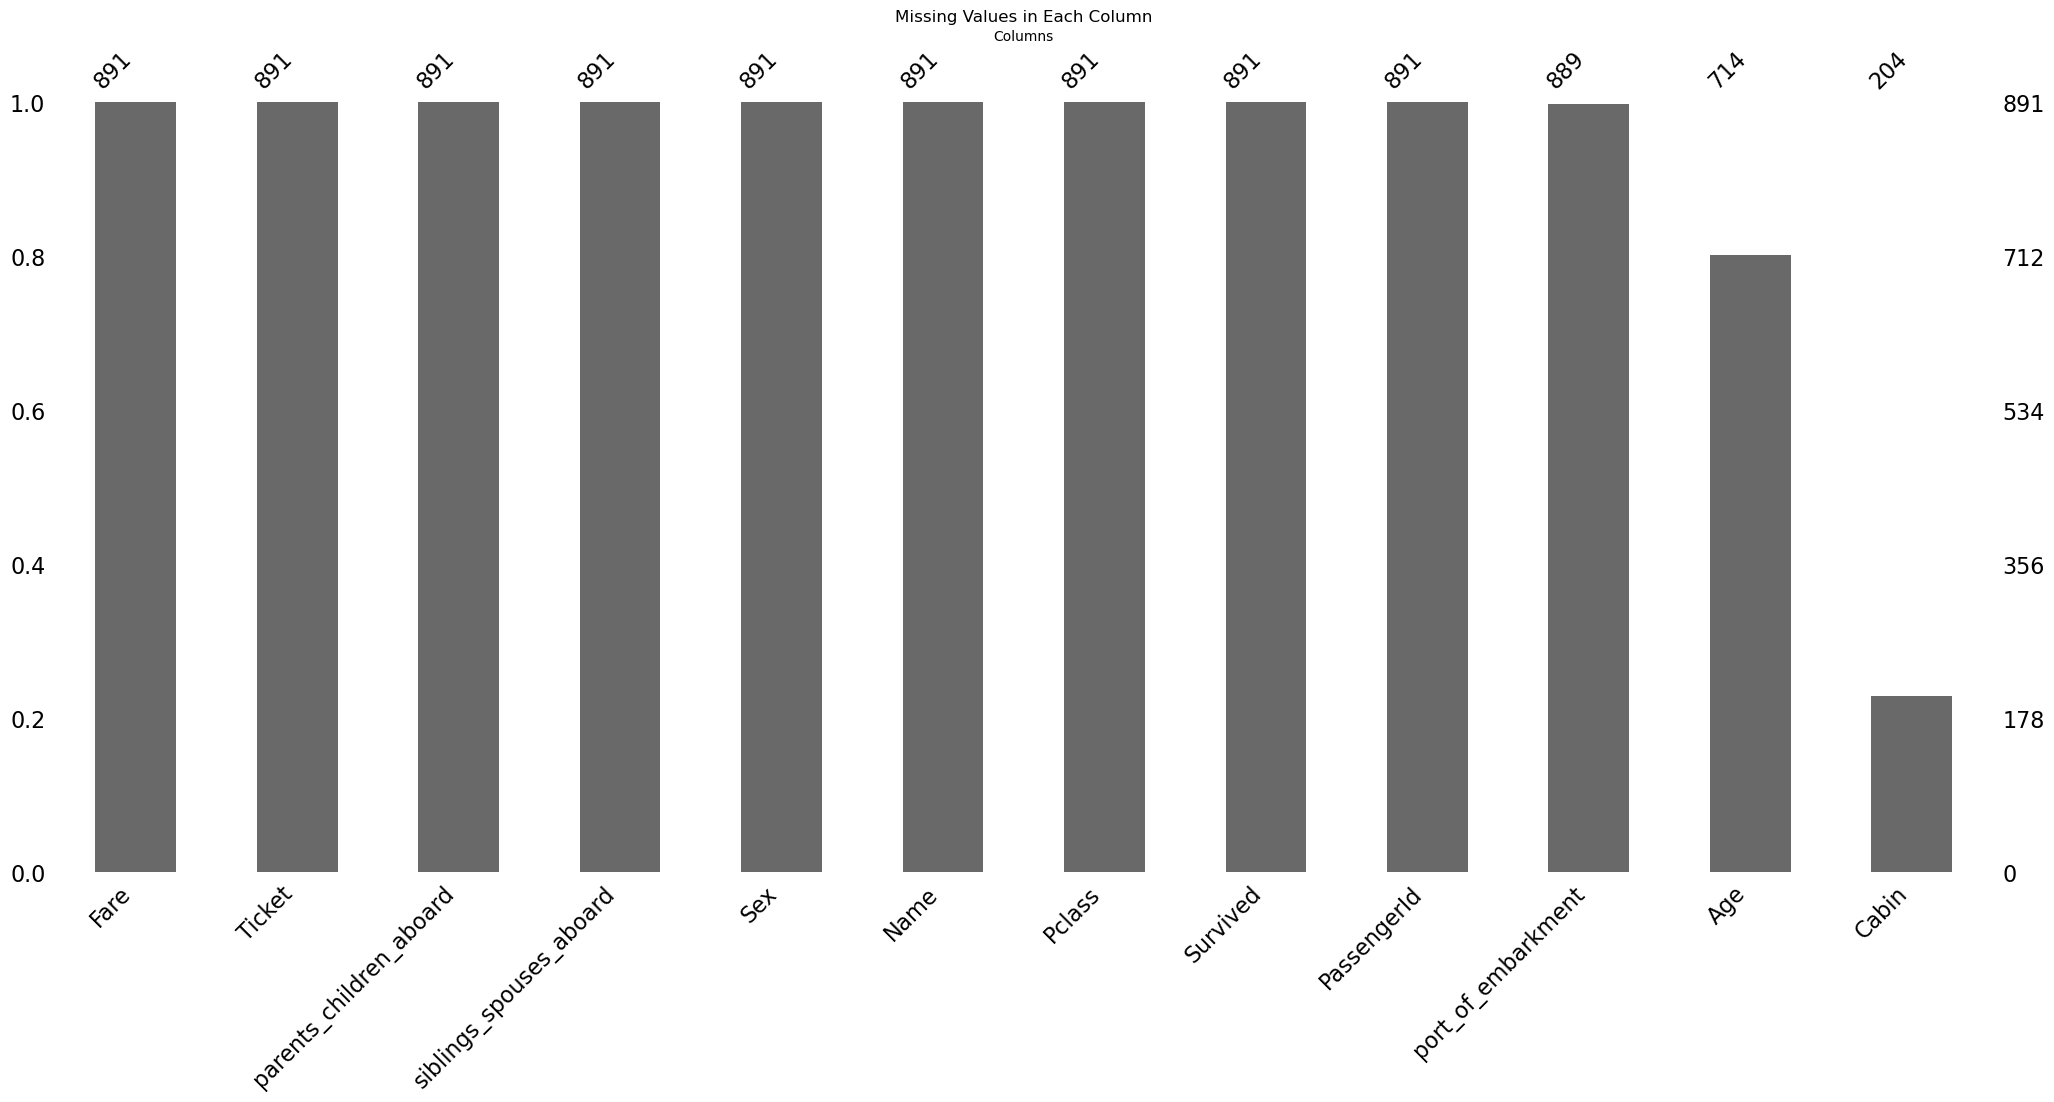

In [22]:
missing_plot = msno.bar(df, sort='descending')
plt.title('Missing Values in Each Column')
plt.ylabel('Percentage')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.show()

In [23]:
# Droppping cabin as it has less than 60% of usable information
# Name and passengerID are not important for prediction, so those can be dropped as well
df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)

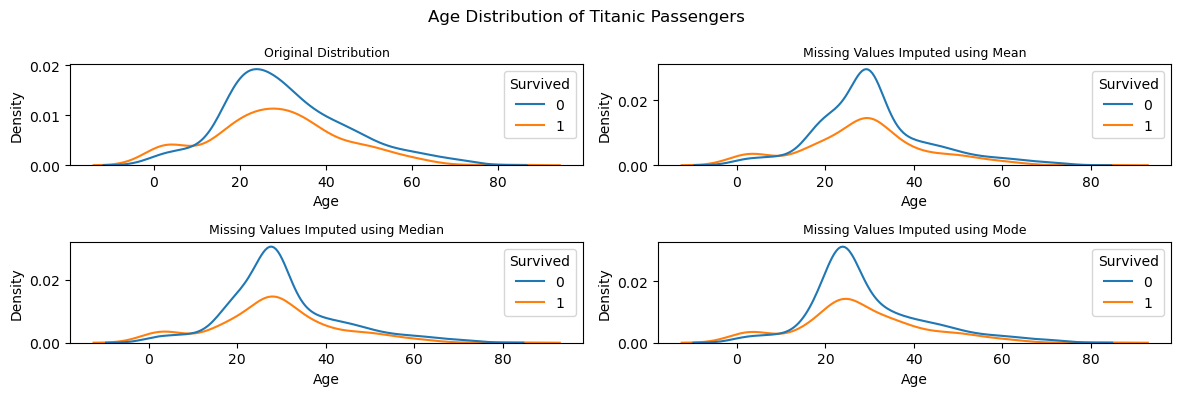

In [24]:
# Looking at the age distribution to determine the best fill method
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 4))
plt.suptitle('Age Distribution of Titanic Passengers')

sns.kdeplot(df['Age'], hue=df['Survived'], ax=ax1)
ax1.set_title('Original Distribution', fontsize=9)

sns.kdeplot(df['Age'].fillna(df['Age'].mean()), hue=df['Survived'], ax=ax2)
ax2.set_title('Missing Values Imputed using Mean', fontsize=9)

sns.kdeplot(df['Age'].fillna(df['Age'].median()), hue=df['Survived'], ax=ax3)
ax3.set_title('Missing Values Imputed using Median', fontsize=9)

sns.kdeplot(df['Age'].fillna(df['Age'].mode().values[0]), hue=df['Survived'], ax=ax4)
ax4.set_title('Missing Values Imputed using Mode', fontsize=9)

plt.tight_layout()
plt.show()

In [25]:
# Based on the above plots, the mode fill looks to most similar to the original distribution, so mode imputation is selected.
df['Age'] = df['Age'].fillna(df['Age'].mode().values[0])

In [26]:
# Filling the port of embarkment using the mode as there are only a few missing values in this column
df['port_of_embarkment'] = df['port_of_embarkment'].fillna(df['port_of_embarkment'].mode())

# Feature Relvance

## Variable Correlation

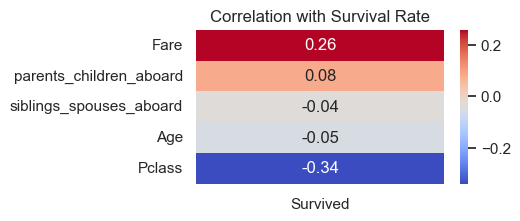

In [63]:
# Looking at the correlation betweeen the numerical variables and the target variable (Rate of survival)
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Survived']
correlation_df = pd.DataFrame(correlation_with_target).drop('Survived')
correlation_df_sorted = correlation_df.sort_values(by='Survived', ascending=False)
plt.figure(figsize=(4, 2))
sns.heatmap(correlation_df_sorted, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with Survival Rate')
plt.show()

- There was the strongest positive relationship with the fare a passenger paid.
- The was the strongest negative relationship with the class of a passenger, which, assuming class 1 is the best class, follows with the point above.
- If you were a child, you were very slightly more likely to survive
- If you were older, you were very slightly less likely to survive

In [28]:
df.select_dtypes(include=['object', 'category']).columns.tolist()

['Sex', 'port_of_embarkment']

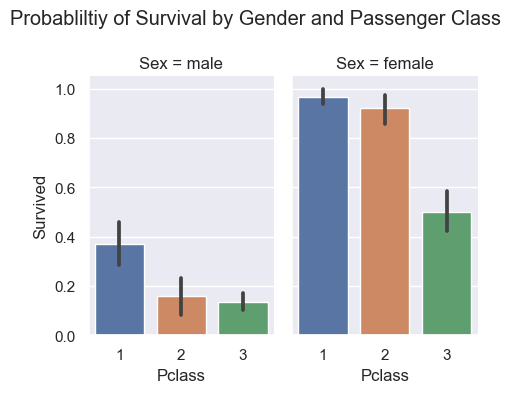

In [61]:
# Looking at the relationship between categorical variables and  the target variable (rate of survival) using box plots
sns.set(style="darkgrid")
sns.catplot(
    data=df, x="Pclass", y="Survived", col="Sex",
    kind="bar", height=4, aspect=.6,
)
plt.suptitle('Probabliltiy of Survival by Gender and Passenger Class')
plt.tight_layout()
plt.show()

- Women were significantly more likely to survive  than men

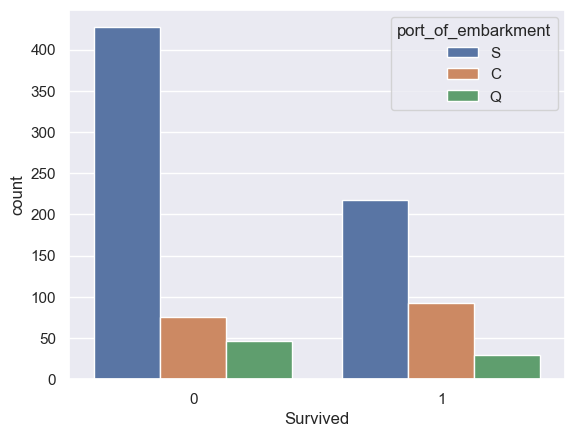

In [68]:
# Looking at the effect of port of embarkment on rate of survival
sns.set(style="darkgrid")
sns.countplot( x='Survived', data=df, hue="port_of_embarkment")
plt.show()

- The port of embakment doesn't seem have a clearly defined effect on the rate of survival.

In [72]:
# Looking at the presence of family memebers on the rate of survival
# df[['parents_children_aboard', 'siblings_spouses_aboard']]
df['relatives_aboard'] = df['siblings_spouses_aboard'] + df['parents_children_aboard']

In [74]:
df['relatives_aboard'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: relatives_aboard, dtype: int64

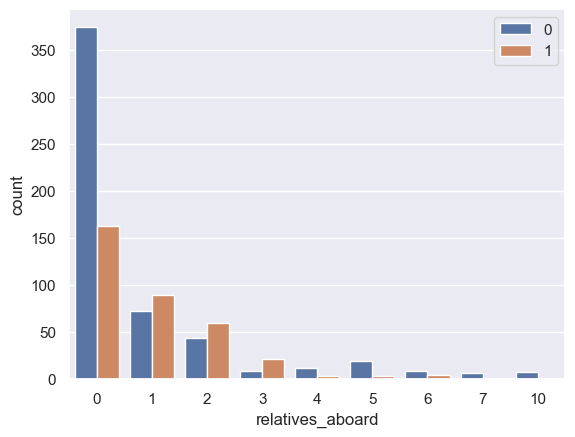

In [86]:
sns.set(style="darkgrid")
#sns.set_palette("Set2") 
ax = sns.countplot( x='relatives_aboard', data=df, hue="Survived")
ax.legend(loc='upper right')
plt.show()

You were more likely to survive if you had 1-3 family members aboard

# Model Selection and Base Case Prediction

In [31]:
X = df.copy()
y = df['Survived']
cat_cols = X.select_dtypes(include='object').columns.tolist()
encoded_df = pd.get_dummies(df[X.select_dtypes(include='object').columns.tolist()])
X = pd.concat([df, encoded_df], axis=1)
X.drop('Survived', axis=1, inplace=True)
X.drop(cat_cols, axis=1, inplace=True)

In [32]:
%%capture
# Automated classification model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyClassifier
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
class_models_bc, class_predictions_bc = clf.fit(X_train, X_test, y_train, y_test)

In [33]:
class_models_bc.head()

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.84,0.83,0.83,0.84,0.09
LabelPropagation,0.82,0.81,0.81,0.82,0.02
XGBClassifier,0.82,0.81,0.81,0.82,0.07
RandomForestClassifier,0.82,0.80,0.80,0.81,0.14
LabelSpreading,0.82,0.80,0.80,0.81,0.02


# Feature Selection

### Manual Feature Selection Results: 

- Gender
- Passenger Class
- Fare 
- Number of relatives aboard

Are the most important features, in that order.

In [34]:
X = df.copy()
y = df['Survived']
cat_cols = X.select_dtypes(include='object').columns.tolist()
encoded_df = pd.get_dummies(df[X.select_dtypes(include='object').columns.tolist()])
X = pd.concat([df, encoded_df], axis=1)
X.drop('Survived', axis=1, inplace=True)
X.drop(cat_cols, axis=1, inplace=True)

In [35]:
X.head()

,Pclass,Age,siblings_spouses_aboard,parents_children_aboard,Fare,Sex_female,Sex_male,port_of_embarkment_C,port_of_embarkment_Q,port_of_embarkment_S
0,3,22.00,1,0,7.25,0,1,0,0,1
1,1,38.00,1,0,71.28,1,0,1,0,0
2,3,26.00,0,0,7.92,1,0,0,0,1
3,1,35.00,1,0,53.10,1,0,0,0,1
4,3,35.00,0,0,8.05,0,1,0,0,1


In [36]:
from sklearn.feature_selection import SelectKBest, f_classif
k = 3 
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
print(selected_features)

Index(['Pclass', 'Sex_female', 'Sex_male'], dtype='object')


In [37]:
%%capture
X = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
class_models, class_predictions = clf.fit(X_train, X_test, y_train, y_test)

In [38]:
class_models.head()

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.77,0.78,0.78,0.77,0.01
AdaBoostClassifier,0.78,0.77,0.77,0.78,0.07
LinearDiscriminantAnalysis,0.78,0.77,0.77,0.78,0.01
SGDClassifier,0.78,0.77,0.77,0.78,0.02
RidgeClassifierCV,0.78,0.77,0.77,0.78,0.01


Note that additional accuracy was not acheieved for selectkbest features, in this case we use the best performing model on the entire dataset: LGBMClassifier

## Base Case LGBMClassifier Model

In [45]:
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score

X = df.copy()
cat_cols = X.select_dtypes(include='object').columns.tolist()
encoded_df = pd.get_dummies(df[X.select_dtypes(include='object').columns.tolist()])
X = pd.concat([df, encoded_df], axis=1)
X.drop('Survived', axis=1, inplace=True)
X.drop(cat_cols, axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       105
           1       0.80      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



## Feature Slection on LGBMClassifier Model

In [41]:
X = df.copy()
cat_cols = X.select_dtypes(include='object').columns.tolist()
encoded_df = pd.get_dummies(df[X.select_dtypes(include='object').columns.tolist()])
X = pd.concat([df, encoded_df], axis=1)
X.drop('Survived', axis=1, inplace=True)
X.drop(cat_cols, axis=1, inplace=True)

In [42]:
from sklearn.feature_selection import RFECV

# Perform Recursive Feature Elimination (RFE)
estimator_rfe = lgbm  # Replace YourEstimator with your desired estimator for RFE
selector_rfe = RFECV(estimator_rfe, step=1, cv=5)  # Modify parameters as needed
selector_rfe.fit(X, y)
selected_features_rfe = X.columns[selector_rfe.support_]

print("Selected features using RFE:", selected_features_rfe.tolist())

Selected features using RFE: ['Pclass', 'Age', 'siblings_spouses_aboard', 'parents_children_aboard', 'Fare', 'Sex_female', 'port_of_embarkment_S']


In [43]:
X = X[selected_features_rfe.tolist()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       105
           1       0.81      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



# Hyper-Parameter Tuning

Default Hyperparameters: 
LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1,
               n_estimators=100, subsample_for_bin=200000, objective=None,
               class_weight=None, min_split_gain=0.0, min_child_weight=0.001,
               min_child_samples=20, subsample=1.0, subsample_freq=0,
               colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,
               random_state=None, n_jobs=-1, silent=True, importance_type='split')

In [91]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

def objective(params):
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

space = {
    'learning_rate': hp.choice('learning_rate', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
    'max_depth': hp.choice('max_depth', range(-8, 8)),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500, 600]),
}

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

best_hyperparams = space_eval(space, best)

model = LGBMClassifier(**best_hyperparams)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy:", accuracy)

100%|██████████| 100/100 [00:08<00:00, 11.75trial/s, best loss: -0.8435754189944135]
Final Accuracy: 0.8435754189944135


In [92]:
best_hyperparams

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100}

In [93]:
X = df.copy()
cat_cols = X.select_dtypes(include='object').columns.tolist()
encoded_df = pd.get_dummies(df[X.select_dtypes(include='object').columns.tolist()])
X = pd.concat([df, encoded_df], axis=1)
X.drop('Survived', axis=1, inplace=True)
X.drop(cat_cols, axis=1, inplace=True)

X = X[selected_features_rfe.tolist()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lgbm = LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=100)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       105
           1       0.81      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



In [94]:
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy:", accuracy)

Final Accuracy: 0.8435754189944135


# Emsemble Modelling

In [95]:
from sklearn.semi_supervised import LabelPropagation

lgbm_model = LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=100)
label_prop_model = LabelPropagation()

lgbm_model.fit(X_train, y_train)
label_prop_model.fit(X_train, y_train)

lgbm_pred = lgbm_model.predict(X_test)
label_prop_pred = label_prop_model.predict(X_test)

combined_pred = (lgbm_pred + label_prop_pred) / 2

threshold = 0.5
combined_pred_labels = (combined_pred > threshold).astype(int)

accuracy = accuracy_score(y_test, combined_pred_labels)
print('Combined Model Accuracy:', accuracy)

Combined Model Accuracy: 0.8324022346368715


In [49]:
from sklearn.ensemble import VotingClassifier
from sklearn.semi_supervised import LabelPropagation

# Create individual models
lgbm_model = LGBMClassifier()
label_prop_model = LabelPropagation()

# Create the ensemble model using voting
ensemble_model = VotingClassifier([('lgbm', lgbm_model), ('label_prop', label_prop_model)], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Generate predictions using the ensemble model
y_pred = ensemble_model.predict(X_test)

# Evaluate the ensemble model's performance
accuracy = accuracy_score(y_test, y_pred)
print('Ensemble Model Accuracy:', accuracy)

Ensemble Model Accuracy: 0.8268156424581006


In [50]:
from sklearn.ensemble import StackingClassifier

estimators = [('lgbm', lgbm_model), ('label_prop', label_prop_model)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LGBMClassifier())

stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)

accuracy = accuracy_score(y_test, stacking_pred)
print('Stacking Model Accuracy:', accuracy)

Stacking Model Accuracy: 0.7988826815642458
